# Comparing Explanation Methods with deit_tiny_finetuned

This notebook loads a finetuned deit_tiny_patch16_224 model (with a custom head and weights), then runs several explanation methods on each image from a dataset (e.g., COVID-Q). It creates a composite image comparing the different explanation masks.



deit_tiny_finetuned


Using cache found in /users/eleves-b/2022/edouard.rabasse/.cache/torch/hub/facebookresearch_deit_main


Found 8 images.
Processing dataset/covid_1579.png
Doing Attention Rollout
Doing Gradient Attention Rollout
Doing New Transformer Explainability Method
Method explainability failed on dataset/covid_1579.png: Cannot use both regular backward hooks and full backward hooks on a single Module. Please use only one of them.
Doing LRP Exact Method
Method LRP_exact failed on dataset/covid_1579.png: Model does not have a relprop method
1 LRP_exact 10.649797
Saved composite image to comparisons/composite_covid_1579.png


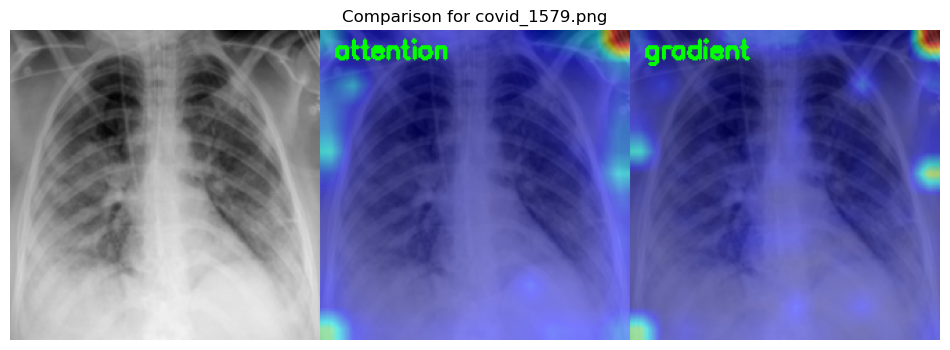

Processing dataset/covid_1582.png
Doing Attention Rollout
Doing Gradient Attention Rollout
Doing New Transformer Explainability Method
Method explainability failed on dataset/covid_1582.png: Cannot use both regular backward hooks and full backward hooks on a single Module. Please use only one of them.
Doing LRP Exact Method
Method LRP_exact failed on dataset/covid_1582.png: Model does not have a relprop method
1 LRP_exact 14.45929
Saved composite image to comparisons/composite_covid_1582.png


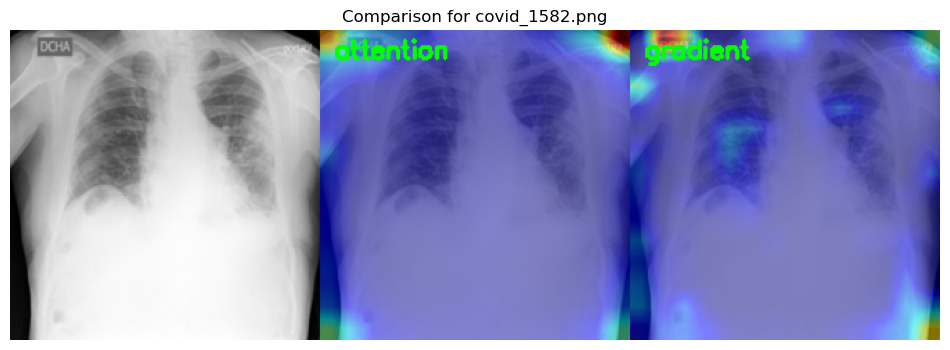

Processing dataset/covid_1592.png
Doing Attention Rollout
Doing Gradient Attention Rollout
Doing New Transformer Explainability Method
Method explainability failed on dataset/covid_1592.png: Cannot use both regular backward hooks and full backward hooks on a single Module. Please use only one of them.
Doing LRP Exact Method
Method LRP_exact failed on dataset/covid_1592.png: Model does not have a relprop method
1 LRP_exact 10.039254
Saved composite image to comparisons/composite_covid_1592.png


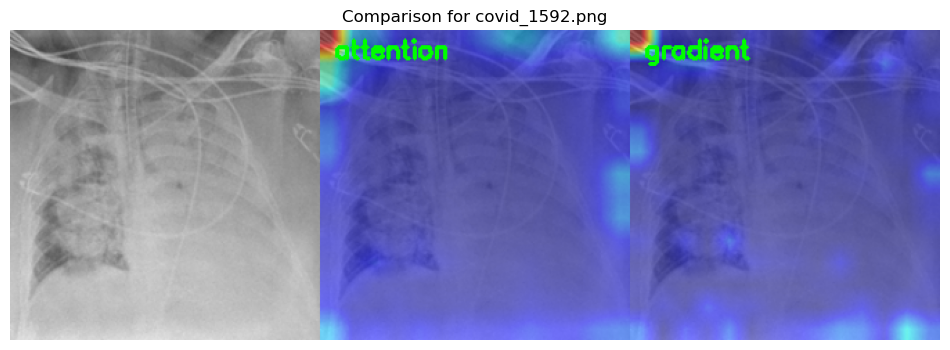

Processing dataset/non_COVID (3248).png
Doing Attention Rollout
Doing Gradient Attention Rollout
Doing New Transformer Explainability Method
Method explainability failed on dataset/non_COVID (3248).png: Cannot use both regular backward hooks and full backward hooks on a single Module. Please use only one of them.
Doing LRP Exact Method
Method LRP_exact failed on dataset/non_COVID (3248).png: Model does not have a relprop method
1 LRP_exact 9.452768
Saved composite image to comparisons/composite_non_COVID (3248).png


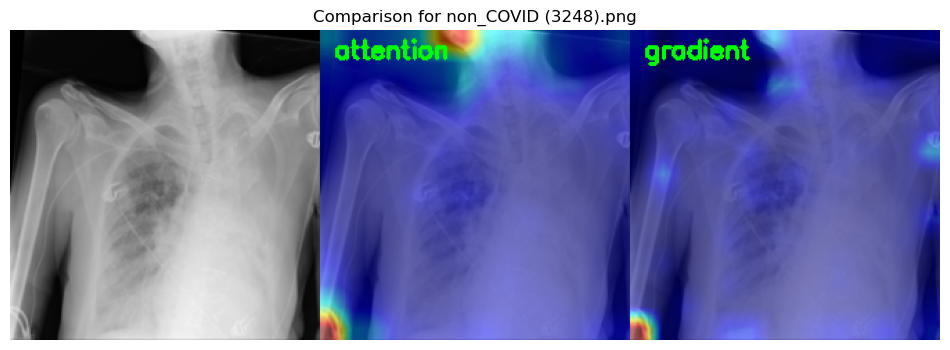

Processing dataset/non_COVID (3249).png
Doing Attention Rollout
Doing Gradient Attention Rollout
Doing New Transformer Explainability Method
Method explainability failed on dataset/non_COVID (3249).png: Cannot use both regular backward hooks and full backward hooks on a single Module. Please use only one of them.
Doing LRP Exact Method
Method LRP_exact failed on dataset/non_COVID (3249).png: Model does not have a relprop method
1 LRP_exact 13.987114
Saved composite image to comparisons/composite_non_COVID (3249).png


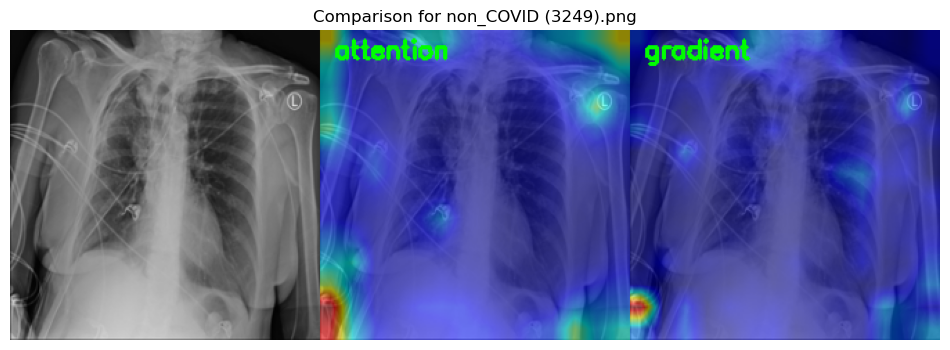

Processing dataset/non_COVID (3250).png
Doing Attention Rollout
Doing Gradient Attention Rollout
Doing New Transformer Explainability Method
Method explainability failed on dataset/non_COVID (3250).png: Cannot use both regular backward hooks and full backward hooks on a single Module. Please use only one of them.
Doing LRP Exact Method
Method LRP_exact failed on dataset/non_COVID (3250).png: Model does not have a relprop method
1 LRP_exact 39.25324
Saved composite image to comparisons/composite_non_COVID (3250).png


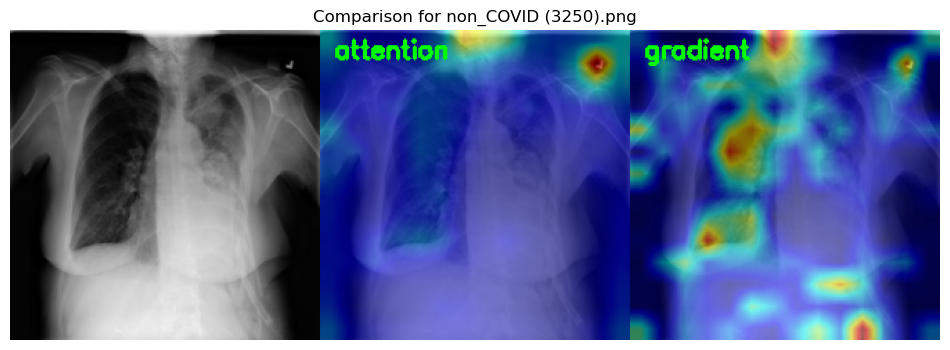

Processing dataset/non_COVID (3251).png
Doing Attention Rollout
Doing Gradient Attention Rollout
Doing New Transformer Explainability Method
Method explainability failed on dataset/non_COVID (3251).png: Cannot use both regular backward hooks and full backward hooks on a single Module. Please use only one of them.
Doing LRP Exact Method
Method LRP_exact failed on dataset/non_COVID (3251).png: Model does not have a relprop method
1 LRP_exact 10.776929
Saved composite image to comparisons/composite_non_COVID (3251).png


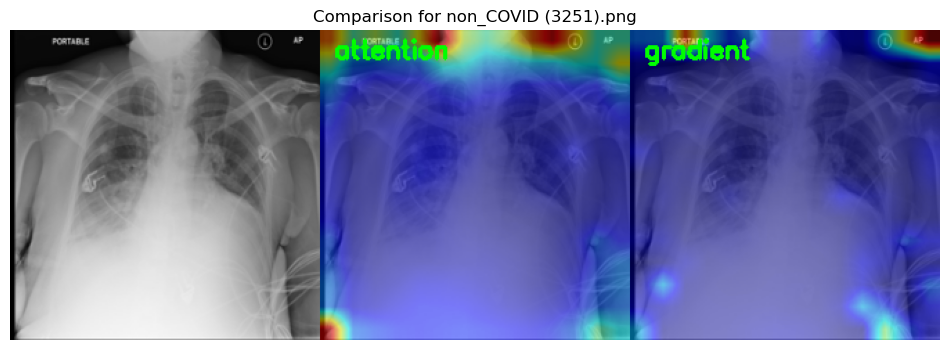

Processing dataset/non_COVID (3252).png
Doing Attention Rollout
Doing Gradient Attention Rollout
Doing New Transformer Explainability Method
Method explainability failed on dataset/non_COVID (3252).png: Cannot use both regular backward hooks and full backward hooks on a single Module. Please use only one of them.
Doing LRP Exact Method
Method LRP_exact failed on dataset/non_COVID (3252).png: Model does not have a relprop method
1 LRP_exact 17.169086
Saved composite image to comparisons/composite_non_COVID (3252).png


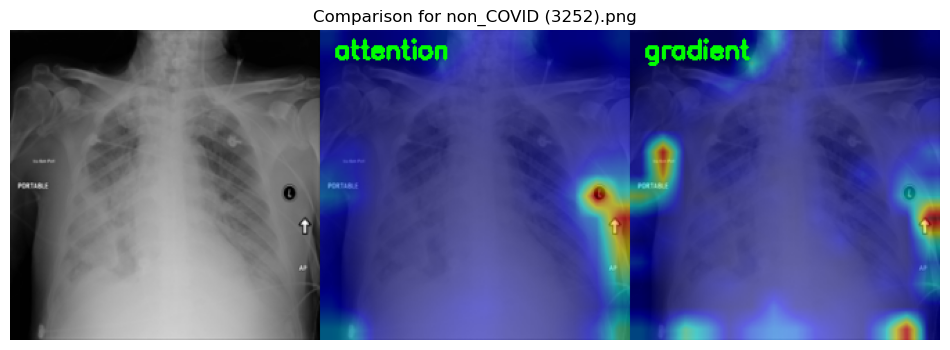

In [4]:
import os
import glob
import cv2
import json
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from types import SimpleNamespace
# Import your explanation functions and model loading functions
# Adjust these imports to point to your modules
from vit_explain_modulable import run_explanation, load_model, show_mask_on_image
# from load_deit import load_deit  # if used in your fine-tuning function

# Custom finetuned model loader


# A helper function to create a composite image from the original and masks
def create_composite(original_img, results_dict):
    orig = np.array(original_img)  # in RGB
    orig = cv2.cvtColor(orig, cv2.COLOR_RGB2BGR)
    orig = cv2.resize(orig, (224, 224))
    composite_images = [orig]
    for method, mask in results_dict.items():
        m = cv2.resize(mask, (orig.shape[1], orig.shape[0]))
        overlay = show_mask_on_image(orig, m)
        cv2.putText(overlay, method, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        composite_images.append(overlay)
    comp = np.hstack(composite_images)
    return comp

# Define a dictionary of methods to compare
methods = ["attention", "gradient", "explainability", "LRP_exact"]

# Parameters for the model, as a dictionary (this was originally passed as a JSON string)
model_parameters = {"pretrained": True, "weights_path": "weights/deit_tiny_head_weights.pth"}

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Transformation for the input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Create a dummy args dictionary (simulate command-line arguments)
args_dict = {
    "category_index": None,
    "discard_ratio": 0.9,
    "head_fusion": "mean",
    "attention_layer_name": "attn_drop",
    "model_name": "deit_tiny_finetuned"
}

args = SimpleNamespace(**args_dict)

# Load the finetuned model
model = load_model(args.model_name, model_parameters)
model = model.to(device)
model.eval()


# %% [markdown]
# ## Process Images and Compare Explanation Methods
# Loop over a subset of images from the dataset and generate composite images.

# Get list of images from dataset directory (adjust extension if necessary)
dataset_dir = "dataset"  # update to your dataset directory
output_dir = "comparisons"
os.makedirs(output_dir, exist_ok=True)
image_files = glob.glob(os.path.join(dataset_dir, "*.[jp][pn]g"))

print(f"Found {len(image_files)} images.")
# image_files = ["examples/a.png"]

# Process only a few images for demonstration (e.g., first 5 images)
for img_path in image_files:
    print("Processing", img_path)
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)
    results = {}
    for method in methods:
        try:
            # Here, we assume run_explanation is defined and imported from your module
            from vit_explain_modulable import run_explanation
            mask, _ = run_explanation(method, model, input_tensor, args)
            # print output
            results[method] = mask
        except Exception as e:
            print(f"Method {method} failed on {img_path}: {e}")
    
    print(model(input_tensor).argmax().item(), method, mask.sum())

    # mask, _ = run_explanation("LRP_exact", model, input_tensor, args)
    composite = create_composite(img, results)
    base_name = os.path.basename(img_path)
    out_path = os.path.join(output_dir, f"composite_{base_name}")
    cv2.imwrite(out_path, composite)
    print("Saved composite image to", out_path)
    plt.figure(figsize=(12,6))
    plt.imshow(cv2.cvtColor(composite, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Comparison for {base_name}")
    plt.show()
